In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm as tqdm
from PIL import Image
import os
from pathlib import Path
from datetime import datetime
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from model.MusicScaleNet import MusicScaleNet

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

print(device)

cuda


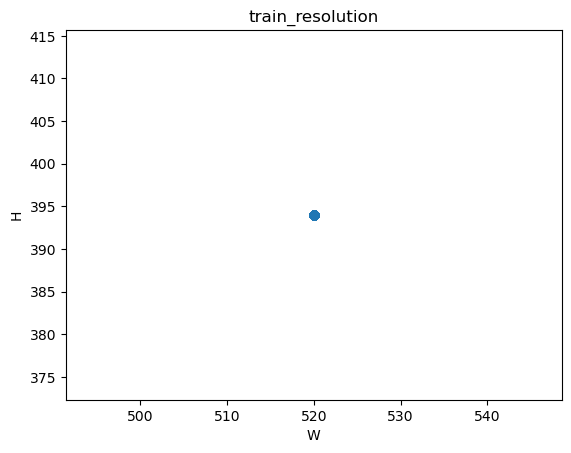

In [3]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# 設定圖片所在的文件夾路徑
folder_path = 'data/music_train/'

# 初始化一個空列表來儲存圖片的分辨率
resolutions = []

# 遍歷文件夾中的所有文件
for filename in os.listdir(folder_path):
    # 判斷是否為圖片文件
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        # 打開圖片文件
        img = Image.open(os.path.join(folder_path, filename))
        # 獲取圖片的分辨率並添加到列表中
        resolutions.append(img.size)

# # 打印出所有圖片的分辨率
# for resolution in resolutions:
#     print(resolution)


# 將分辨率拆分為兩個列表：寬度和高度
widths, heights = zip(*resolutions)

# 創建散點圖
plt.scatter(widths, heights)

# 設置x軸和y軸的標籤
plt.xlabel('W')
plt.ylabel('H')

# 設置標題
plt.title('train_resolution')

# 顯示圖形
plt.show()


88


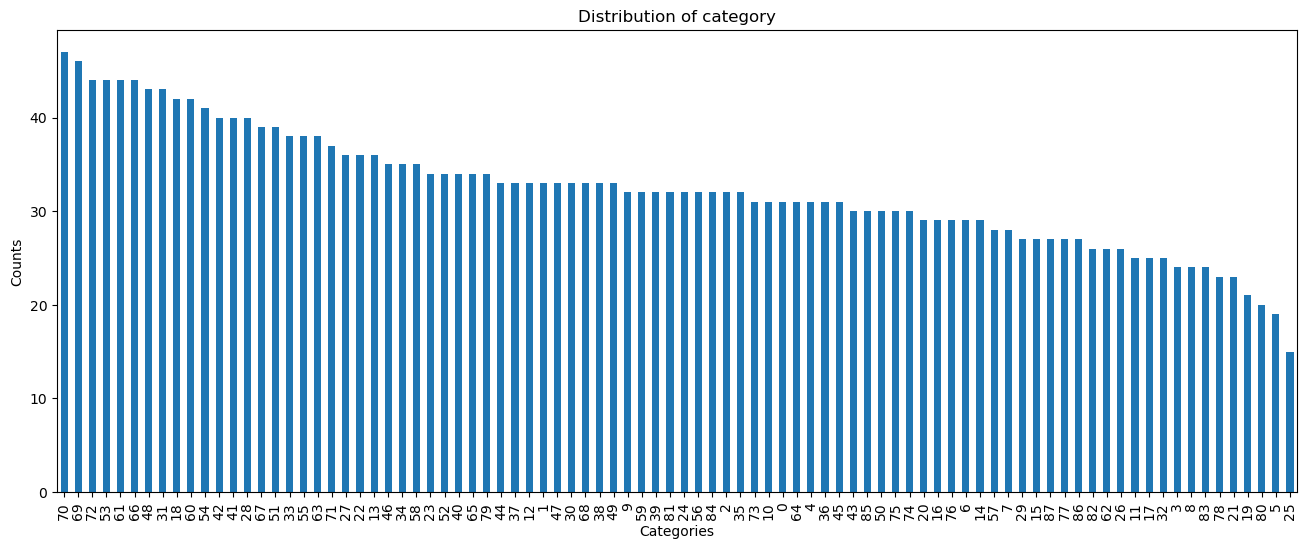

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 從CSV文件中讀取數據
df = pd.read_csv('train_truth.csv')

# 選擇要繪製圖表的列
column = 'category'

# 計算每個值的數量
counts = df[column].value_counts()

# 印出類別的數量
print(len(counts))

# 創建一個新的圖形，設置其寬度為10英寸，高度為6英寸
plt.figure(figsize=(16, 6))

# 創建條形圖
counts.plot(kind='bar')

# 設置x軸和y軸的標籤
plt.xlabel('Categories')
plt.ylabel('Counts')

# 設置標題
plt.title('Distribution of ' + column)

# 顯示圖形
plt.show()

In [5]:
# data_dir = str(Path(fr'BoardState_SD_1120512.csv'))
# testdata_dir = str(Path(fr"./data/test.csv"))
save_dir = str(Path(fr"./runs/exp"))

In [6]:
num_workers = 8
batch_size = 16
epoch_num = 200

LR = 1e-3
EPS = 1e-9
LR_STEP = 20
LR_GAMMA = 0.7

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)  # 從csv文件中讀取數據
        self.transform = transforms.ToTensor()  # 將圖像轉換為張量

    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # 文件名在第一列
        label = self.data.iloc[idx, 1]  # 類別在第二列
        path = fr'data/music_train/{img_name}'  # 構建圖像文件的路徑
        image = Image.open(path).convert('RGB')  # 打開並將圖像轉換為RGB
        image = self.transform(image)  # 將圖像轉換為張量
        return image, label  # 返回圖像和標籤


In [8]:
# 創建一個自定義的圖像數據集對象
dataset = CustomImageDataset('train_truth.csv')

# 計算訓練集的大小，通常是數據集的80%
train_size = int(0.8 * len(dataset))

# 驗證集的大小就是剩餘的部分
val_size = len(dataset) - train_size

# 使用random_split函數隨機分割數據集為訓練集和驗證集
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

# 創建一個數據加載器的字典，對訓練集和驗證集分別進行加載
# shuffle參數設為True表示在每個訓練時期開始時，數據加載器會重新洗牌數據
dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_dataset, valid_dataset], [True, False])}

# 打印整個數據集的大小
print(len(dataset))


2846


In [23]:
from torchvision.models import resnet50

model_name =  MusicScaleNet

# 設定不同網路的參數
model_kwargs = {
    'block': 'InvertedResidualBlock', 
    'block_config': [[2, 6, 64, 1], [2, 6, 64, 2], [2, 6, 128, 2], [2, 6, 256, 2], [2, 6, 512, 2]]
}
model_kwargs = {
    'block': 'ResBlock', 
    'block_config': [[2, 64, 1], [2, 64, 2], [2, 128, 2], [2, 256, 2], [2, 512, 2]]
}

# # 初始化模型
# model = resnet50()


model = MusicScaleNet(**model_kwargs)

# 選擇優化器，使用AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=EPS)
# 使用SGD作為優化器
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# 使用ReduceLROnPlateau學習率調度器，當某指標停止改進時，減少學習率
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.5, 
                                                          patience=30, 
                                                          verbose=True, 
                                                          threshold=0.0001, 
                                                          threshold_mode='rel', 
                                                          cooldown=50, 
                                                          min_lr=0, 
                                                          eps=EPS)

# 使用ReduceLROnPlateau學習率調度器，當epoch計數器到一定值後會更先學習率
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)

# 選擇損失函數，這裡我們使用交叉熵損失函數
criterion = nn.CrossEntropyLoss()


In [24]:
# 導入ptflops庫，用於獲取模型的複雜度信息
from ptflops import get_model_complexity_info

# 指定使用第一塊GPU（索引為0）
with torch.cuda.device(0):
    # 獲取模型的複雜度信息，包括MACs和參數數量
    macs, params = get_model_complexity_info(model, (3, 520, 394), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    # 打印模型的計算複雜度（MACs）
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    # 打印模型的參數數量
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))


ResNet(
  25.56 M, 100.000% Params, 17.39 GMac, 100.000% MACs, 
  (conv1): Conv2d(9.41 k, 0.037% Params, 481.88 MMac, 2.771% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 6.56 MMac, 0.038% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0, 0.000% Params, 3.28 MMac, 0.019% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 3.28 MMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    215.81 k, 0.844% Params, 2.79 GMac, 16.054% MACs, 
    (0): Bottleneck(
      75.01 k, 0.293% Params, 970.3 MMac, 5.579% MACs, 
      (conv1): Conv2d(4.1 k, 0.016% Params, 52.72 MMac, 0.303% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 1.65 MMac, 0.009% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(36.86 k, 0.144% Params, 47

In [11]:
ckpt = {
    'epoch': 0,
    'model_name': model_name,
    'model_args': model_kwargs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'criterion': criterion,
    'history': {
        'train_loss': [], 
        'valid_loss': [],
        'train_top1_accuracy': [], 
        'valid_top1_accuracy': [],
        'valid_loss_min': np.Inf,
        'train_loss_min': np.Inf,
        'best_acc': 0.0,
    },
    'readme': "",
    'date': datetime.now().isoformat(),
}

In [12]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # 增加文件或目錄路徑，例如將 runs/exp 變成 runs/exp{sep}2, runs/exp{sep}3, ... 等等。
    path = Path(path)  # 使路徑符合作業系統

    if path.exists() and not exist_ok:
        # 如果路徑存在且不允許重複，則進行增量操作
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # 增加路徑
            if not os.path.exists(p):  # 如果新路徑不存在，則跳出迴圈
                break
        path = Path(p)  # 將新路徑轉換為 Path 物件

    if mkdir:
        # 如果 mkdir 為 True，則創建新目錄
        path.mkdir(parents=True, exist_ok=True)  

    return str(path)  # 返回字符串形式的路徑


In [13]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # 增加文件或目錄路徑，例如將 runs/exp 變成 runs/exp{sep}2, runs/exp{sep}3, ... 等等。
    path = Path(path)  # 使路徑符合作業系統

    if path.exists() and not exist_ok:
        # 如果路徑存在且不允許重複，則進行增量操作
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # 增加路徑
            if not os.path.exists(p):  # 如果新路徑不存在，則跳出迴圈
                break
        path = Path(p)  # 將新路徑轉換為 Path 物件

    if mkdir:
        # 如果 mkdir 為 True，則創建新目錄
        path.mkdir(parents=True, exist_ok=True)  

    return str(path)  # 返回字符串形式的路徑



In [14]:
def train(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=100,
          dtype=torch.float32, 
          device='cpu'):

    # 將儲存目錄轉換為 Path 物件
    save_dir = Path(save_dir)
    # 使用 increment_path 增加儲存目錄的路徑，避免複寫先前資料
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)

    # 將模型移動到指定的裝置上，同步model的資料型別(要跟data 相同，不然會報錯)
    model = model.to(dtype=dtype).to(device)

    # 以存檔來初始化模型、優化器、學習率調度器和損失函數，如果程式碼意外停止，也能以ckpt來繼續訓練
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    # 開始訓練循環
    for epoch in range(1, num_epochs + 1):

        # 初始化訓練和驗證的損失和準確率
        train_loss = 0.0
        valid_loss = 0.0
        train_top1 = 0.0
        valid_top1 = 0.0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # 設定模型為訓練模式
        model.train()
        for x, y in tqdm(dataloaders['train']):
            # 將優化器中的梯度清零
            optimizer.zero_grad()
            # 將輸入和標籤移動到指定的裝置上
            x = x.to(device)
            y = y.to(device)

            # 前向傳播，計算預測和損失
            predictions = model(x)
            loss = criterion(predictions, y)
            # 反向傳播，計算梯度
            loss.backward()
            # 使用優化器更新權重
            optimizer.step()

            # 累計訓練損失和準確率
            train_loss += loss.item() * x.size(0)
            train_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 設定模型為驗證模式
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(dataloaders['valid']):
                # 將輸入和標籤移動到指定的裝置上
                x = x.to(device)
                y = y.to(device)

                # 前向傳播，計算預測和損失
                predictions = model(x)
                loss = criterion(predictions, y)

                # 累計驗證損失和準確率
                valid_loss += loss.item() * x.size(0)
                valid_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 如果有設置學習率調度器，則以驗證損失作為指標調整學習率
        if (lr_scheduler):
            lr_scheduler.step(valid_loss)

        # 計算訓練和驗證的平均損失和準確率
        train_loss = train_loss / len(dataloaders['train'].sampler)
        valid_loss = valid_loss / len(dataloaders['valid'].sampler)
        train_top1_acc = train_top1 / len(dataloaders['train'].sampler)
        valid_top1_acc = valid_top1 / len(dataloaders['valid'].sampler)

        # 將這一輪的訓練和驗證損失和準確率添加到歷史記錄中
        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['valid_loss'].append(valid_loss)
        ckpt['history']['train_top1_accuracy'].append(train_top1_acc)
        ckpt['history']['valid_top1_accuracy'].append(valid_top1_acc)

        # 打印這一輪的訓練和驗證損失和準確率
        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        print(
            f'Train top1 acc -> {train_top1_acc:.6f}      \
                Validation top1 acc -> {valid_top1_acc:.6f}')

        # 更新和保存檢查點信息
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # 如果驗證損失降低，則保存模型
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('valid_best.pth')))

        # 每10輪保存一次檢查點
        if (epoch) % 10 == 0:
            torch.save(ckpt, str(Path(save_dir) / Path(f'ckpt_{epoch}.pth')))
        torch.save(ckpt, str(Path(save_dir) / Path(f'last.pth')))

In [15]:
ckpt = train(ckpt, save_dir, model, dataloaders, optimizer, lr_scheduler=lr_scheduler, num_epochs=10, device=device)

running epoch: 1


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.951281                      Validation loss     -> 0.010852
Train top1 acc -> 0.852812                      Validation top1 acc -> 0.998246
Validation loss decreased (inf                     --> 0.010852).  Saving model ...
running epoch: 2


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.019425                      Validation loss     -> 0.230428
Train top1 acc -> 0.996924                      Validation top1 acc -> 0.984211
running epoch: 3


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.101968                      Validation loss     -> 0.815934
Train top1 acc -> 0.982425                      Validation top1 acc -> 0.817544
running epoch: 4


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.068589                      Validation loss     -> 0.008777
Train top1 acc -> 0.985940                      Validation top1 acc -> 0.994737
Validation loss decreased (0.010852                     --> 0.008777).  Saving model ...
running epoch: 5


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.013105                      Validation loss     -> 0.000325
Train top1 acc -> 0.997364                      Validation top1 acc -> 1.000000
Validation loss decreased (0.008777                     --> 0.000325).  Saving model ...
running epoch: 6


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.000730                      Validation loss     -> 0.000059
Train top1 acc -> 1.000000                      Validation top1 acc -> 1.000000
Validation loss decreased (0.000325                     --> 0.000059).  Saving model ...
running epoch: 7


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.000771                      Validation loss     -> 0.000051
Train top1 acc -> 1.000000                      Validation top1 acc -> 1.000000
Validation loss decreased (0.000059                     --> 0.000051).  Saving model ...
running epoch: 8


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.000260                      Validation loss     -> 0.000024
Train top1 acc -> 1.000000                      Validation top1 acc -> 1.000000
Validation loss decreased (0.000051                     --> 0.000024).  Saving model ...
running epoch: 9


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.000170                      Validation loss     -> 0.000020
Train top1 acc -> 1.000000                      Validation top1 acc -> 1.000000
Validation loss decreased (0.000024                     --> 0.000020).  Saving model ...
running epoch: 10


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Train loss     -> 0.000143                      Validation loss     -> 0.000017
Train top1 acc -> 1.000000                      Validation top1 acc -> 1.000000
Validation loss decreased (0.000020                     --> 0.000017).  Saving model ...


In [17]:
ckpt = torch.load(str(Path(fr"./runs/exp9") / Path('last.pth')))

Text(0, 0.5, 'acc')

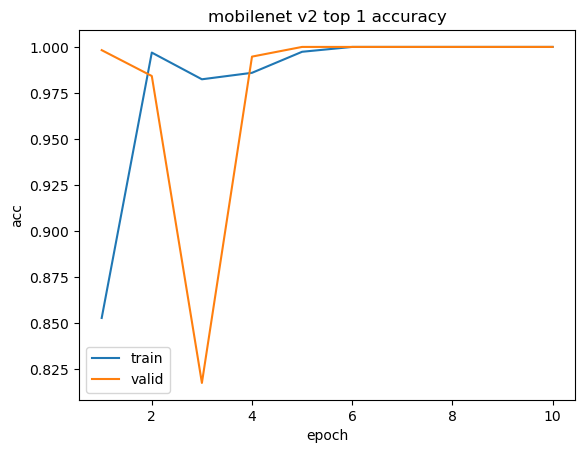

In [18]:
# 畫圖，只會畫前十個
# n = len(ckpt['history']['train_top1_accuracy'])
n = 10
epochs = range(1, n + 1)
plt.plot(epochs, ckpt['history']['train_top1_accuracy'][:n],label='train')
plt.plot(epochs, ckpt['history']['valid_top1_accuracy'][:n],label='valid')
# plt.xlim(50,)
# plt.ylim(0,0.1)
plt.legend()
plt.title('mobilenet v2 top 1 accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')


In [23]:
import os
import pandas as pd
import torch
from torchvision.transforms import ToTensor
from PIL import Image

def predict_and_save(model, folder_path, output_csv):
    # 創建一個將 PIL 圖片轉換為張量的轉換器
    transform = ToTensor()
    # 創建一個空的列表來保存結果
    results = []

    # 遍歷指定目錄下的所有文件
    for filename in os.listdir(folder_path):
        # 如果文件是 PNG 圖片
        if filename.endswith(".png"): 
            # 獲取圖片的完整路徑
            image_path = os.path.join(folder_path, filename)
            # 打開並將圖片轉換為 RGB
            image = Image.open(image_path).convert('RGB')
            # 將圖片轉換為張量並增加一個維度以匹配模型的輸入
            image_tensor = transform(image).unsqueeze(0)

            # 如果 CUDA 可用，則將模型和圖片張量移至 GPU
            if torch.cuda.is_available():  
                model = model.cuda()
                image_tensor = image_tensor.cuda()

            # 將模型設為評估模式
            model.eval()
            # 不計算梯度，因為這是推論，不需要反向傳播
            with torch.no_grad():
                # 進行預測
                prediction = model(image_tensor)
                # 從預測結果中獲取最大概率類別的索引
                category = prediction.argmax().item()
                # 將文件名和預測類別添加到結果列表中
                results.append((filename, category))

    # 將結果列表轉換為 DataFrame
    results_df = pd.DataFrame(results, columns=["filename", "category"])
    # 將結果 DataFrame 寫入 CSV 文件
    results_df.to_csv(output_csv, index=False)


# 使用方法
predict_and_save(model, "data/music_test", "output.csv")
